#  Detector geometry for AGIPD

The AGIPD detector, which is already in use at the SPB experiment, consists of 16 modules of 512×128 pixels each. Each module is further divided into 8 ASICs.

To view or analyse detector data, we need to apply geometry to find the positions of pixels.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from karabo_data import RunDirectory, stack_detector_data
from karabo_data.geometry2 import AGIPD_1MGeometry

Fetch AGIPD detector data for one pulse to test with:

In [2]:
run = RunDirectory('/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/')

In [3]:
tid, train_data = run.select('*/DET/*', 'image.data').train_from_index(60)

In [4]:
stacked = stack_detector_data(train_data, 'image.data')
stacked_pulse = stacked[10]
stacked_pulse.shape

(16, 512, 128)

Generate a simple geometry given the (x, y) coordinates of the first pixel in the first module of each quadrant, in pixel units relative to the centre, where the beam passes through the detector.

There are also methods to load and save CrystFEL format geometry files.

In [5]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
        (-525, 625),
        (-550, -10),
        (520, -160),
        (542.5, 475),
    ])

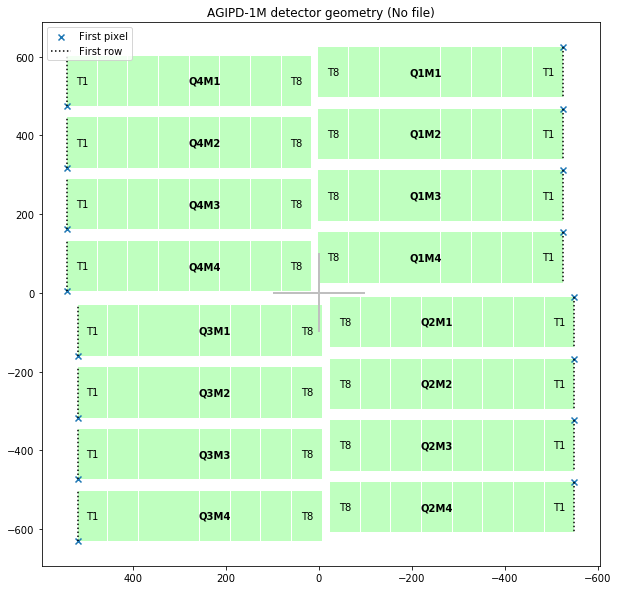

In [6]:
geom.inspect()

The pixels are not necessarily all aligned, so precisely assembling data in a 2D array requires interpolation, which is slow:

In [7]:
%%time
data, centre_yx = geom.position_modules_interpolate(stacked_pulse)
print(data.shape)

(1258, 1094)
CPU times: user 12.2 s, sys: 240 ms, total: 12.5 s
Wall time: 6.58 s


But we know that the modules are closely aligned with the axes, so we can 'snap' the geometry to the grid and copy data more efficiently:

In [8]:
%%time
data, centre_yx = geom.position_modules_fast(stacked_pulse)
print(data.shape)

(1256, 1092)
CPU times: user 29.4 ms, sys: 7.13 ms, total: 36.6 ms
Wall time: 30.5 ms


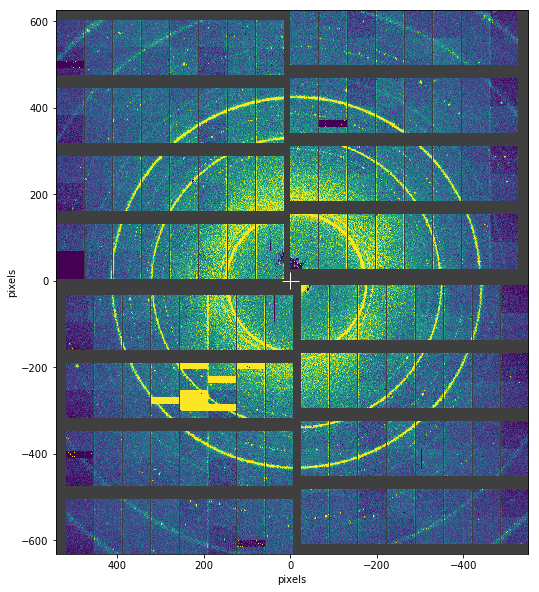

In [9]:
geom.plot_data_fast(np.clip(stacked_pulse, 0, 1000))

## Converting array positions to physical positions

We can also convert array coordinates within the detector data into real (x, y, z) positions in metres.

In [10]:
# Generate some array coordinates, one in each module
module_no = np.arange(0, 16)
# For AGIPD, slow-scan is the x dimension, increasing from the edges towards the centre
slow_scan = np.linspace(10, 500, num=16)
fast_scan = np.full(fill_value=40.1, shape=16)  # Fixed y position in each module

positions.shape = (16, 3)


(600, -600)

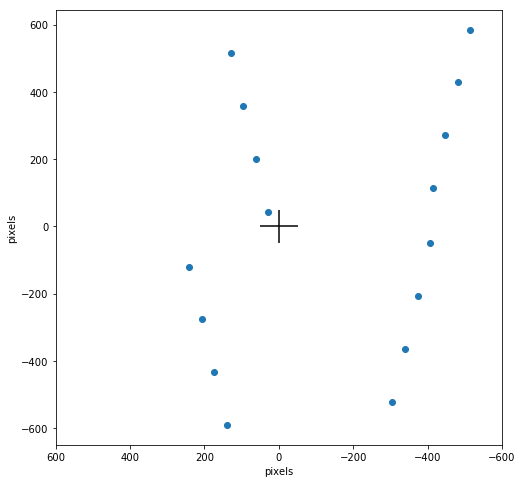

In [11]:
positions = geom.data_coords_to_positions(module_no, slow_scan, fast_scan)
print("positions.shape =", positions.shape)  # (point, x/y/z)

# Convert metres to pixel units to compare with plots above
px = positions[:, 0] / geom.pixel_size
py = positions[:, 1] / geom.pixel_size

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(px, py)

ax.set_xlabel('pixels')
ax.set_ylabel('pixels')
ax.hlines(0, -50, 50)  # Draw a cross at the origin
ax.vlines(0, -50, 50)  #
ax.set_xlim(600, -600)  # Invert x-axis to match plots above